In [92]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline
pd.set_option('display.max_columns', 50)

# Дополнительные данные, которые отсутсвовали в базе
## Расход топлива
Для оценки расхода топлива в пассажирских самолетах приоритетным показателем является грамм/пасс-км, т.к. позволяет точнее рассчитать расход в зависимости от кол-ва пассажиров. Однако такой показатель есть не для каждого самолета, поэтому другим, более универсальным, является показатель кг/час. Он показывает сколько кг топлива расходует самолет на крейсерской скорости в час, является менее точным т.к. не учитывает загруженность самолета, однако представлен в характеристике каждого для каждого судна. 
В наших данных при перевозках используются две модели самолетов: boeing и sukhoi. Для боинга есть все данные по расходу топлива, а для российской модели только расход кг/час. Таким образом я принял решение посчитать для боинга расход по 2 показателям для каждого рейса и взять среднее, а для "сухого" только по кг/час.
## Цена топлива
Цены на авиатопливо отличаются в зависимости от региона и аэропорта. Данные получены на сайте росавиации по состоянию на февраль 2017 года для аэропорта Анапы. 2017 год взят т.к. анализируются рейсы 2017 года.

In [93]:
fuel_per_pas = {'boeing': 26, 'sukhoi': None} # gramm per passenger per 1 km
fuel_per_hour = {'boeing': 2.4, 'sukhoi': 1.7} # ton per hour
fuel_price = 49700 # Цена за тонну топлива в аэропорту Анапы в 2017г

# Рассчет дополнительных показателей 
## Длина перелёта
Для рассчета длины перелёта применяется функция, принимающая данные широты и долготы двух точек,и учитывает радиус земли. Найдена при помощи гугл.
## Стоимость топлива на перелёт
На определенный рейс, заправляя самолет учитывают:
1. Топливо необходимое для преодоления расстояния до аэропорта назначении. 
2. Топливо для полета от аэропорта назначение до запасного аэродрома.
3. Горючее для ожидания посадки в течение 30 минут на малой высоте.
4. Надбавка 5% на непредвиденные обстоятельства.
На основании этих данных принято решение, в функции для рассчёта стоимости топлива на рейс, к количеству топлива необходимого непосредственно на перелёт из одного аэропорта в другой, прибавлять еще 15% на все остальные случаи.
В процессе исследования данных было обнаружено, что по перелётам в Новокузнецк отсутсвуют данные о проданных билетах. Таким образом для полетов в Новокузнецк стоимость рассчитывается по показателю "кг/час".
Для других рейсов на судне "боинг" стоимость рассчитывется по двум показателям ("кг/час", "гр/пасс-км") и берется среднее, как говорилось выше. 
Для рейсов на российском судне "суперджет сухой" стоимость рассчитывалась только по показателю "кг/час".

In [134]:
def distanceBetweenKm(lat1, lon1, lat2, lon2):
    dLat = math.radians(lat2-lat1)
    dLon = math.radians(lon2-lon1)

    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    a = math.sin(dLat/2)**2 + math.sin(dLon/2)**2 * math.cos(lat1) * math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return round(c * 6371, 0)  #multiply by 100k to get distance in cm

def count_costs_flight(x):
    if x['aircraft_code']=='733':
        if x['arrival_airport']=='NOZ':
            n = (fuel_per_hour['boeing']/60) * x['flight_lasts_min'] * fuel_price
            return round(n*1.15, 0)
        p = (x['economy_sold']+x['business_sold']) * x['flight_distance'] * fuel_per_pas['boeing']/1000000 * fuel_price
        h = (fuel_per_hour['boeing']/60) * x['flight_lasts_min'] * fuel_price
        return round(((p + h)/2)*1.15, 0)
    if x['aircraft_code']=='SU9':
        s = (fuel_per_hour['sukhoi']/60) * x['flight_lasts_min'] * fuel_price
        return round(s*1.15, 0)

In [135]:
df = pd.read_csv('airlines_anapa.csv')

In [136]:
df[df['arrival_airport']=='NOZ']

,flight_id,departure,arrival,departure_airport,arrival_airport,aircraft_code,economy_sold,comfort_sold,business_sold,price_eco_sold,price_bus_sold,price_total,aircraft_model,aircraft_range,amount_eco_seats,amount_bus_seats,total_seats,total_booking_price,arrival_city,airport_longitude,airport_latitude,anapa_long,anapa_lat
8,136511,2017-02-21T06:10:00Z,2017-02-21T11:15:00Z,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102
9,136523,2017-01-10T06:10:00Z,2017-01-10T11:15:00Z,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102
10,136540,2017-01-17T06:10:00Z,2017-01-17T11:15:00Z,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102
11,136546,2017-01-03T06:10:00Z,2017-01-03T11:15:00Z,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102
38,136560,2017-01-24T06:10:00Z,2017-01-24T11:15:00Z,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102
79,136513,2017-02-28T06:10:00Z,2017-02-28T11:15:00Z,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102
80,136514,2017-02-07T06:10:00Z,2017-02-07T11:15:00Z,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102
81,136567,2017-02-14T06:10:00Z,2017-02-14T11:15:00Z,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102
117,136544,2017-01-31T06:10:00Z,2017-01-31T11:15:00Z,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            127 non-null    int64  
 1   departure            127 non-null    object 
 2   arrival              127 non-null    object 
 3   departure_airport    127 non-null    object 
 4   arrival_airport      127 non-null    object 
 5   aircraft_code        127 non-null    object 
 6   economy_sold         118 non-null    float64
 7   comfort_sold         0 non-null      float64
 8   business_sold        118 non-null    float64
 9   price_eco_sold       118 non-null    float64
 10  price_bus_sold       118 non-null    float64
 11  price_total          118 non-null    float64
 12  aircraft_model       127 non-null    object 
 13  aircraft_range       127 non-null    int64  
 14  amount_eco_seats     127 non-null    int64  
 15  amount_bus_seats     127 non-null    int

In [138]:
df['perc_sold'] = (df['economy_sold'] + df['business_sold']) / df['total_seats']

In [139]:
df = df.drop(columns = ['comfort_sold'])

In [140]:
df['flight_distance'] = df.apply(
    lambda x: distanceBetweenKm(x['anapa_lat'], x['anapa_long'], x['airport_latitude'], x['airport_longitude']), axis=1)

In [141]:
df['flight_distance']

0      1220.0
1      1220.0
2      1220.0
3      1220.0
4      1220.0
        ...  
122     630.0
123     630.0
124     630.0
125     630.0
126     630.0
Name: flight_distance, Length: 127, dtype: float64

In [142]:
df['departure'] = df['departure'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))

In [143]:
df['arrival'] = df['arrival'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))

In [144]:
df['flight_lasts_min'] = df['arrival']-df['departure']

In [145]:
df['flight_lasts_min'] = df['flight_lasts_min'].apply(lambda x: x.seconds/60)

In [146]:
df['flight_costs'] = df.apply((lambda x: count_costs_flight(x)), axis=1)

In [147]:
df['flight_costs']

0      202238.0
1      211303.0
2      221274.0
3      215836.0
4      214929.0
         ...   
122     80970.0
123     80970.0
124     80970.0
125     80970.0
126     80970.0
Name: flight_costs, Length: 127, dtype: float64

In [148]:
df.head(5)

,flight_id,departure,arrival,departure_airport,arrival_airport,aircraft_code,economy_sold,business_sold,price_eco_sold,price_bus_sold,price_total,aircraft_model,aircraft_range,amount_eco_seats,amount_bus_seats,total_seats,total_booking_price,arrival_city,airport_longitude,airport_latitude,anapa_long,anapa_lat,perc_sold,flight_distance,flight_lasts_min,flight_costs
0,136122,2017-01-08 10:05:00,2017-01-08 11:45:00,AAQ,SVO,733,87.0,10.0,1065000.0,366000.0,1431000.0,Boeing 737-300,4200,118,12,130,5411400.0,Moscow,37.4146,55.972599,37.347301,45.002102,0.746154,1220.0,100.0,202238.0
1,136130,2017-02-13 10:05:00,2017-02-13 11:45:00,AAQ,SVO,733,97.0,10.0,1190600.0,366000.0,1556600.0,Boeing 737-300,4200,118,12,130,5795200.0,Moscow,37.4146,55.972599,37.347301,45.002102,0.823077,1220.0,100.0,211303.0
2,136181,2017-01-31 10:05:00,2017-01-31 11:45:00,AAQ,SVO,733,108.0,10.0,1323600.0,366000.0,1689600.0,Boeing 737-300,4200,118,12,130,6961000.0,Moscow,37.4146,55.972599,37.347301,45.002102,0.907692,1220.0,100.0,221274.0
3,136209,2017-01-06 10:05:00,2017-01-06 11:45:00,AAQ,SVO,733,102.0,10.0,1249200.0,366000.0,1615200.0,Boeing 737-300,4200,118,12,130,7017800.0,Moscow,37.4146,55.972599,37.347301,45.002102,0.861538,1220.0,100.0,215836.0
4,136270,2017-02-12 10:05:00,2017-02-12 11:45:00,AAQ,SVO,733,100.0,11.0,1226000.0,402600.0,1628600.0,Boeing 737-300,4200,118,12,130,6539400.0,Moscow,37.4146,55.972599,37.347301,45.002102,0.853846,1220.0,100.0,214929.0


In [149]:
df['revenue'] = df['price_total'] - df['flight_costs']

In [232]:
df.sample(10)
#df['departure'][32].strftime('%A')

,flight_id,departure,arrival,departure_airport,arrival_airport,aircraft_code,economy_sold,business_sold,price_eco_sold,price_bus_sold,price_total,aircraft_model,aircraft_range,amount_eco_seats,amount_bus_seats,total_seats,total_booking_price,arrival_city,airport_longitude,airport_latitude,anapa_long,anapa_lat,perc_sold,flight_distance,flight_lasts_min,flight_costs,revenue,perc_bus_sold
22,136605,2017-02-15 09:25:00,2017-02-15 10:15:00,AAQ,EGO,SU9,85.0,12.0,538500.0,226800.0,765300.0,Sukhoi Superjet-100,3000,85,12,97,5066800.0,Belgorod,36.590099,50.643799,37.347301,45.002102,1.000000,630.0,50.0,80970.0,684330.0,0.123711
14,136875,2017-02-16 09:25:00,2017-02-16 10:15:00,AAQ,EGO,SU9,85.0,12.0,538500.0,226800.0,765300.0,Sukhoi Superjet-100,3000,85,12,97,4880400.0,Belgorod,36.590099,50.643799,37.347301,45.002102,1.000000,630.0,50.0,80970.0,684330.0,0.123711
80,136514,2017-02-07 06:10:00,2017-02-07 11:15:00,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102,NaN,3634.0,305.0,697291.0,NaN,NaN
77,136428,2017-01-21 10:05:00,2017-01-21 11:45:00,AAQ,SVO,733,104.0,11.0,1276000.0,402600.0,1678600.0,Boeing 737-300,4200,118,12,130,7034800.0,Moscow,37.414600,55.972599,37.347301,45.002102,0.884615,1220.0,100.0,218555.0,1460045.0,0.095652
112,136310,2017-01-22 10:05:00,2017-01-22 11:45:00,AAQ,SVO,733,108.0,9.0,1324800.0,329400.0,1654200.0,Boeing 737-300,4200,118,12,130,6529800.0,Moscow,37.414600,55.972599,37.347301,45.002102,0.900000,1220.0,100.0,220368.0,1433832.0,0.076923
30,136907,2017-01-16 09:25:00,2017-01-16 10:15:00,AAQ,EGO,SU9,84.0,12.0,532200.0,226800.0,759000.0,Sukhoi Superjet-100,3000,85,12,97,5080700.0,Belgorod,36.590099,50.643799,37.347301,45.002102,0.989691,630.0,50.0,80970.0,678030.0,0.125000
117,136544,2017-01-31 06:10:00,2017-01-31 11:15:00,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102,NaN,3634.0,305.0,697291.0,NaN,NaN
71,136819,2017-01-04 09:25:00,2017-01-04 10:15:00,AAQ,EGO,SU9,84.0,12.0,532200.0,226800.0,759000.0,Sukhoi Superjet-100,3000,85,12,97,5073200.0,Belgorod,36.590099,50.643799,37.347301,45.002102,0.989691,630.0,50.0,80970.0,678030.0,0.125000
26,136778,2017-02-22 09:25:00,2017-02-22 10:15:00,AAQ,EGO,SU9,84.0,12.0,532200.0,226800.0,759000.0,Sukhoi Superjet-100,3000,85,12,97,4687300.0,Belgorod,36.590099,50.643799,37.347301,45.002102,0.989691,630.0,50.0,80970.0,678030.0,0.125000
95,136348,2017-02-10 10:05:00,2017-02-10 11:45:00,AAQ,SVO,733,108.0,12.0,1323600.0,439200.0,1762800.0,Boeing 737-300,4200,118,12,130,7552600.0,Moscow,37.414600,55.972599,37.347301,45.002102,0.923077,1220.0,100.0,223087.0,1539713.0,0.100000


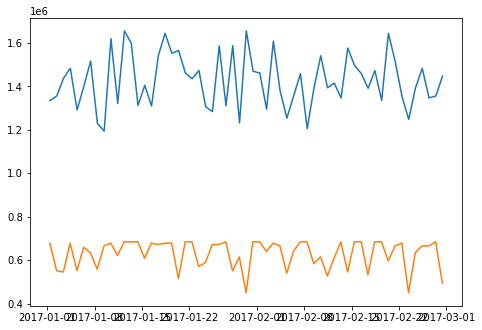

In [176]:
df_M = df.query('arrival_city == "Moscow"').sort_values(by = ['departure'])
#df_M = df_M.loc[:,['departure', 'revenue']].sort_values(by = ['departure'])
df_B = df.query('arrival_city == "Belgorod"').sort_values(by = ['departure'])
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(df_M['departure'], df_M['revenue']) 
axes.plot(df_B['departure'], df_B['revenue'])

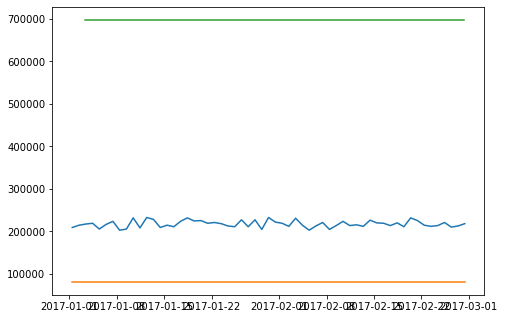

In [174]:
df_cost_M = df.query('arrival_city == "Moscow"').sort_values(by = ['departure'])
df_cost_B = df.query('arrival_city == "Belgorod"').sort_values(by = ['departure'])
df_cost_N = df.query('arrival_city == "Novokuznetsk"').sort_values(by = ['departure'])
fig_cost = plt.figure()
axes_cost = fig_cost.add_axes([0,0,1,1])
axes_cost.plot(df_cost_M['departure'], df_cost_M['flight_costs']) 
axes_cost.plot(df_cost_B['departure'], df_cost_B['flight_costs'])
axes_cost.plot(df_cost_N['departure'], df_cost_N['flight_costs'])

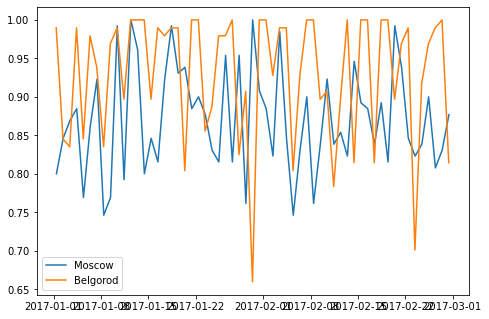

In [181]:
fig_perc = plt.figure()
axes_perc = fig_perc.add_axes([0,0,1,1])
axes_perc.plot(df_M['departure'], df_M['perc_sold'], label = 'Moscow') 
axes_perc.plot(df_B['departure'], df_B['perc_sold'], label = 'Belgorod')
axes_perc.legend(loc=3)
#df_M.loc[:,['departure', 'revenue']].sort_values(by = ['departure'])

In [300]:
def days_not_full(x):
    if x['perc_sold']<=0.85:
        return x['departure'].strftime('%A')
    else:
        return None

def days_full(x):
    if x['perc_sold']>0.85:
        return x['departure'].strftime('%A')
    else:
        return None  

def days(x):
    return x.strftime('%A')

In [301]:
df['days'] = df['departure'].apply(days)

In [248]:
df['days_not_full'] = df.apply(days_not_full, axis=1)
df['days_full'] = df.apply(days_full, axis=1)

In [302]:
rev_mos_d = df.query('arrival_city=="Moscow"').groupby(by=['days'])['revenue'].sum()
rev_belg_d = df.query('arrival_city=="Belgorod"').groupby(by=['days'])['revenue'].sum()

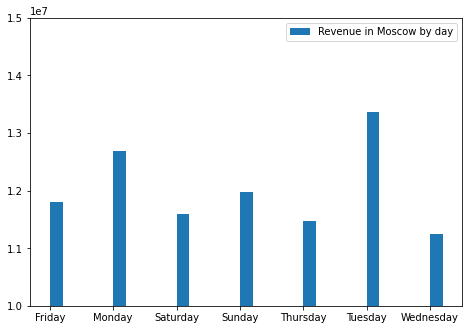

In [307]:
fig_days = plt.figure()
axes_days = fig_days.add_axes([0, 0, 1, 1])
axes_days.set_ylim(1e+7, 1.5e+7)
axes_days.bar(x = rev_mos_d.index, height = rev_mos_d.values, 
                width = 0.2, align = 'edge', label = 'Revenue in Moscow by day')
#axes_days.bar(x = rev_belg_d.index, height = rev_belg_d.values, 
#                width = -0.2, align = 'edge', label = 'Revenue in Belgorod by day')
axes_days.legend(loc = 1)

In [309]:
df.query('arrival_city=="Moscow"')['days'].value_counts()

Sunday       9
Tuesday      9
Monday       9
Wednesday    8
Thursday     8
Saturday     8
Friday       8
Name: days, dtype: int64

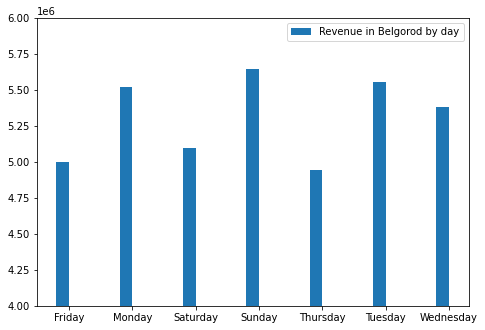

In [312]:
fig_days = plt.figure()
axes_days = fig_days.add_axes([0, 0, 1, 1])
axes_days.set_ylim(4e+6, 6e+6)
#axes_days.bar(x = rev_mos_d.index, height = rev_mos_d.values, 
#                width = 0.2, align = 'edge', label = 'Revenue in Moscow by day')
axes_days.bar(x = rev_belg_d.index, height = rev_belg_d.values, 
                width = -0.2, align = 'edge', label = 'Revenue in Belgorod by day')
axes_days.legend(loc = 1)

In [313]:
df.query('arrival_city=="Belgorod"')['days'].value_counts()

Sunday       9
Tuesday      9
Monday       9
Thursday     8
Friday       8
Saturday     8
Wednesday    8
Name: days, dtype: int64

In [305]:
group_moscow_rev = df.query('arrival_city=="Moscow"').groupby(by=['days_not_full'])['revenue'].sum()
group_belg_rev = df.query('arrival_city=="Belgorod"').groupby(by=['days_not_full'])['revenue'].sum()
group_moscow_rev_full = df.query('arrival_city=="Moscow"').groupby(by=['days_full'])['revenue'].sum()
group_belg_rev_full = df.query('arrival_city=="Belgorod"').groupby(by=['days_full'])['revenue'].sum()

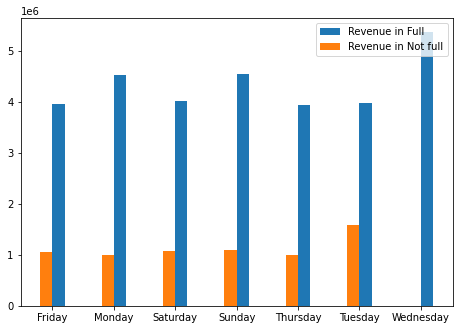

In [298]:
fig_days = plt.figure()
axes_days = fig_days.add_axes([0, 0, 1, 1])
#axes_days.set_ylim(0, 8e+5)
axes_days.bar(x = group_belg_rev_full.index, height = group_belg_rev_full.values, 
                width = 0.2, align = 'edge', label = 'Revenue in Full')
axes_days.bar(x = group_belg_rev.index, height = group_belg_rev.values, 
                width = -0.2, align = 'edge', label = 'Revenue in Not full')
axes_days.legend(loc = 1)

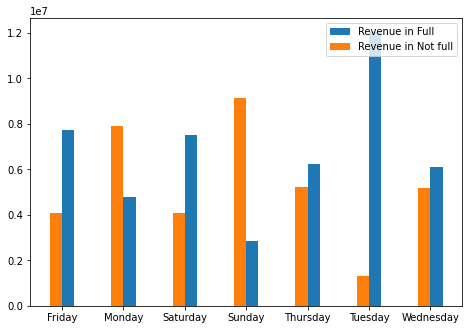

In [299]:
fig_days = plt.figure()
axes_days = fig_days.add_axes([0, 0, 1, 1])
#axes_days.set_ylim(1e+6, 1.7e+6)
axes_days.bar(x = group_moscow_rev_full.index, height = group_moscow_rev_full.values, 
                width = 0.2, align = 'edge', label = 'Revenue in Full')
axes_days.bar(x = group_moscow_rev.index, height = group_moscow_rev.values, 
                width = -0.2, align = 'edge', label = 'Revenue in Not full')
axes_days.legend(loc = 1)

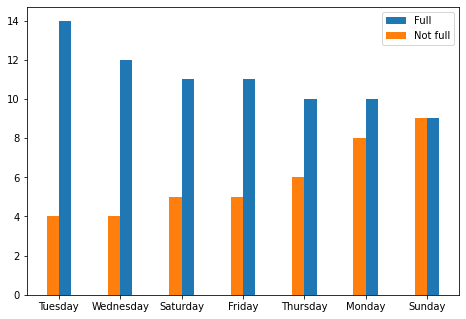

In [273]:
fig_days = plt.figure()
axes_days = fig_days.add_axes([0, 0, 1, 1])
#axes_days.set_ylim(0.7, 1)
axes_days.bar(x = df['days_full'].value_counts().index, height = df['days_full'].value_counts().values, 
                width = 0.2, align = 'edge', label = 'Full')
axes_days.bar(x = df['days_not_full'].value_counts().index, height = df['days_not_full'].value_counts().values, 
                width = -0.2, align = 'edge', label = 'Not full')
axes_days.legend(loc = 1)

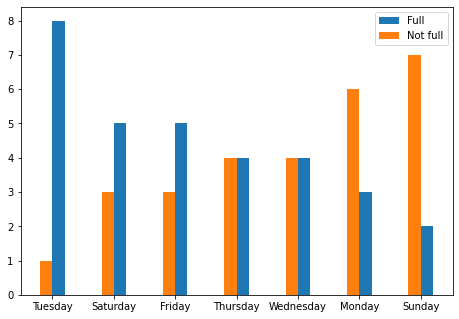

In [279]:
fig_days = plt.figure()
axes_days = fig_days.add_axes([0, 0, 1, 1])
#axes_days.set_ylim(0.7, 1)
axes_days.bar(x = df.query('arrival_city == "Moscow"')['days_full'].value_counts().index, height = df.query('arrival_city == "Moscow"')['days_full'].value_counts().values, 
                width = 0.2, align = 'edge', label = 'Full')
axes_days.bar(x = df.query('arrival_city == "Moscow"')['days_not_full'].value_counts().index, height = df.query('arrival_city == "Moscow"')['days_not_full'].value_counts().values, 
                width = -0.2, align = 'edge', label = 'Not full')
axes_days.legend(loc = 1)

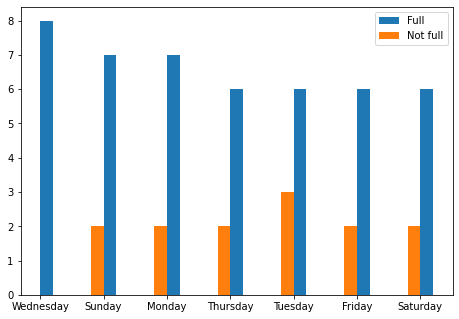

In [280]:
fig_days = plt.figure()
axes_days = fig_days.add_axes([0, 0, 1, 1])
#axes_days.set_ylim(0.7, 1)
axes_days.bar(x = df.query('arrival_city == "Belgorod"')['days_full'].value_counts().index, height = df.query('arrival_city == "Belgorod"')['days_full'].value_counts().values, 
                width = 0.2, align = 'edge', label = 'Full')
axes_days.bar(x = df.query('arrival_city == "Belgorod"')['days_not_full'].value_counts().index, height = df.query('arrival_city == "Belgorod"')['days_not_full'].value_counts().values, 
                width = -0.2, align = 'edge', label = 'Not full')
axes_days.legend(loc = 1)

In [269]:
df['days_full'].value_counts()

Tuesday      14
Wednesday    12
Saturday     11
Friday       11
Thursday     10
Monday       10
Sunday        9
Name: days_full, dtype: int64

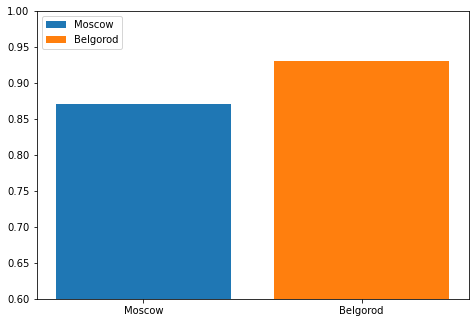

In [275]:
fig_perc_mn = plt.figure()
axes_perc_mn = fig_perc_mn.add_axes([0,0,1,1])
#axes_perc_mn.bar(perc_mean_M, label = 'Moscow') 
#axes_perc_mn.bar(perc_mean_B, label = 'Belgorod')
axes_perc_mn.bar(x = df.query('arrival_city == "Moscow"')['arrival_city'], height = perc_mean_M, label = 'Moscow')
axes_perc_mn.bar(x = df.query('arrival_city == "Belgorod"')['arrival_city'], height = perc_mean_B, 
                 label = 'Belgorod')
axes_perc_mn.set_ylim(0.6, 1)
axes_perc_mn.legend(loc=2)

In [196]:
perc_mean_M = df.query('arrival_city == "Moscow"')['perc_sold'].mean()

In [197]:
perc_mean_B = df.query('arrival_city == "Belgorod"')['perc_sold'].mean()

In [184]:
df['arrival_city'].value_counts()

Belgorod        59
Moscow          59
Novokuznetsk     9
Name: arrival_city, dtype: int64

In [188]:
df['perc_bus_sold'] = df['business_sold'] / (df['economy_sold']+df['business_sold'])

In [189]:
df.query('arrival_city == "Moscow"')['perc_bus_sold'].mean()

0.09290606759153996

In [190]:
df.query('arrival_city == "Belgorod"')['perc_bus_sold'].mean()

0.12265048055919431

In [191]:
df.query('arrival_city == "Moscow"')['business_sold'].mean()

10.508474576271187

In [192]:
df.query('arrival_city == "Belgorod"')['business_sold'].mean()

11.067796610169491